In [9]:
import os
import cv2
import numpy as np
import torch

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)

2.6.0+cu124


In [2]:
def load_dat_file(filepath, shape=(224, 224)):
    data = np.fromfile(filepath, dtype=np.float32)
    return data.reshape(shape)

def compute_metrics(pred, target, threshold=0.5):
    # Convert predictions to binary masks (if not already binary)
    pred_bin = (pred > threshold).astype(np.uint8)
    target_bin = (target > threshold).astype(np.uint8)

    # Compute intersection and union for IoU
    intersection = np.logical_and(pred_bin, target_bin).sum()
    union = np.logical_or(pred_bin, target_bin).sum()
    iou = intersection / union if union != 0 else 0.0

    # Compute Dice coefficient
    pred_sum = pred_bin.sum()
    target_sum = target_bin.sum()
    dice = (2.0 * intersection) / (pred_sum + target_sum) if (pred_sum + target_sum) != 0 else 0.0

    return iou, dice

In [3]:
dataset_path = "/home/dmatveev/workdir/datasets/Geobody"
seismic_dir = os.path.join(dataset_path, "seismic")
label_dir   = os.path.join(dataset_path, "label")

In [4]:
sam2_checkpoint = "/home/dmatveev/workdir/rosneft_segmentation/models/sam2.1_hiera_base_plus.pt"  # Path to model weights
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"       # путь к конфигу с префиксом file://

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [5]:
sam2_model

SAM2Base(
  (image_encoder): ImageEncoder(
    (trunk): Hiera(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 112, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0-1): 2 x MultiScaleBlock(
          (norm1): LayerNorm((112,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=112, out_features=336, bias=True)
            (proj): Linear(in_features=112, out_features=112, bias=True)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((112,), eps=1e-06, elementwise_affine=True)
          (mlp): MLP(
            (layers): ModuleList(
              (0): Linear(in_features=112, out_features=448, bias=True)
              (1): Linear(in_features=448, out_features=112, bias=True)
            )
            (act): GELU(approximate='none')
          )
        )
        (2): MultiScaleBlock(
          (norm1): LayerNorm((112,), eps=1e-06, elementwise_affi

In [11]:
all_files = sorted(os.listdir(seismic_dir))
val_files = all_files[-10:]

In [12]:
val_files

['990.dat',
 '991.dat',
 '992.dat',
 '993.dat',
 '994.dat',
 '995.dat',
 '996.dat',
 '997.dat',
 '998.dat',
 '999.dat']

File: 990.dat, IoU: 0.0000, Dice: 0.0000


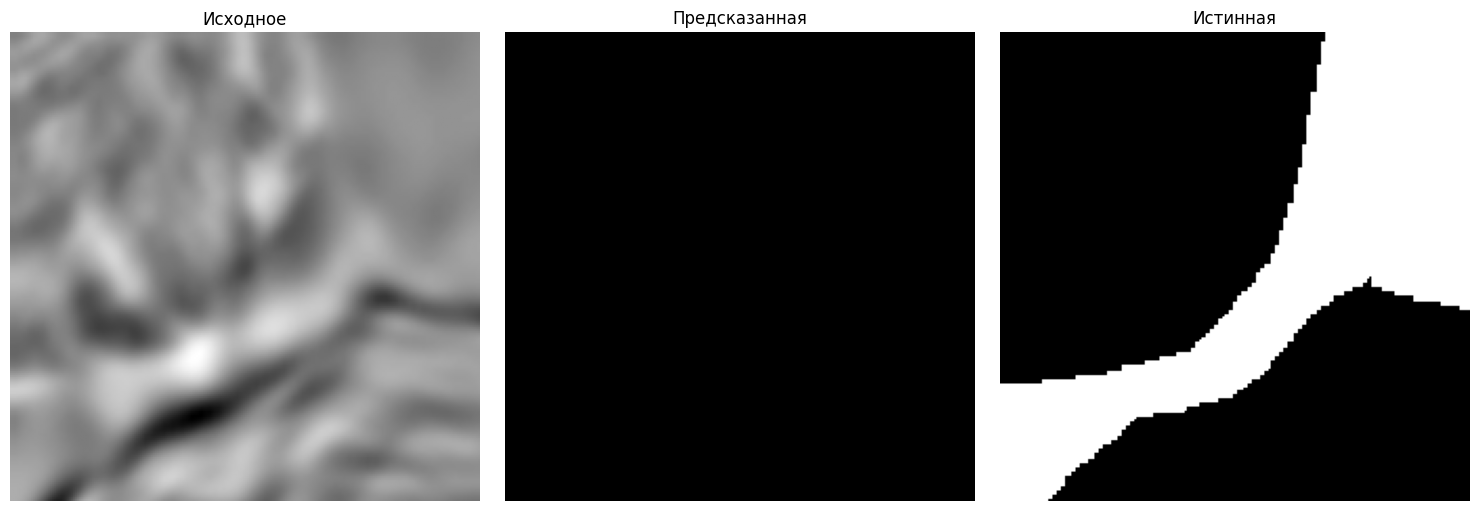

File: 991.dat, IoU: 0.0000, Dice: 0.0000


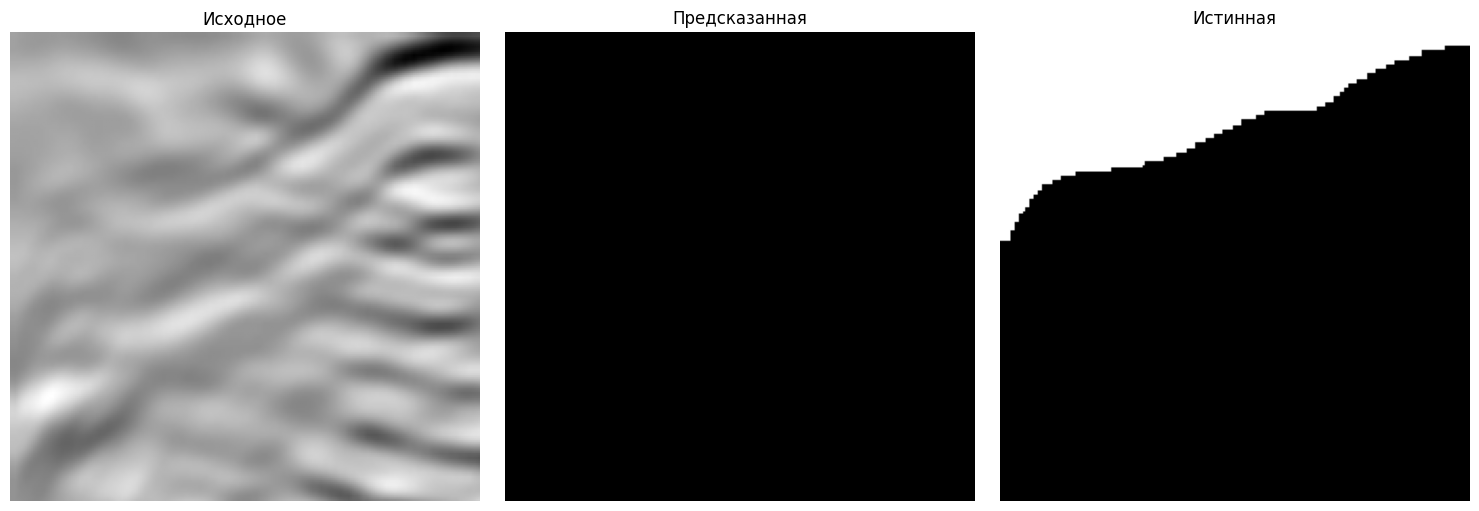

File: 992.dat, IoU: 0.0000, Dice: 0.0000


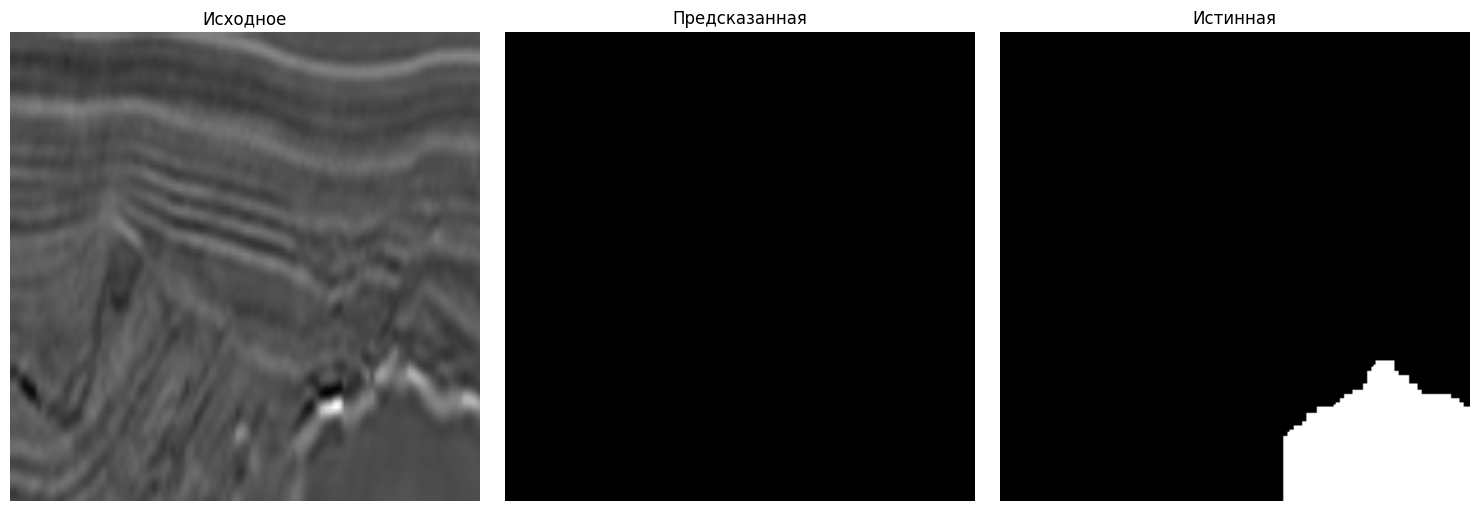

File: 993.dat, IoU: 0.0000, Dice: 0.0000


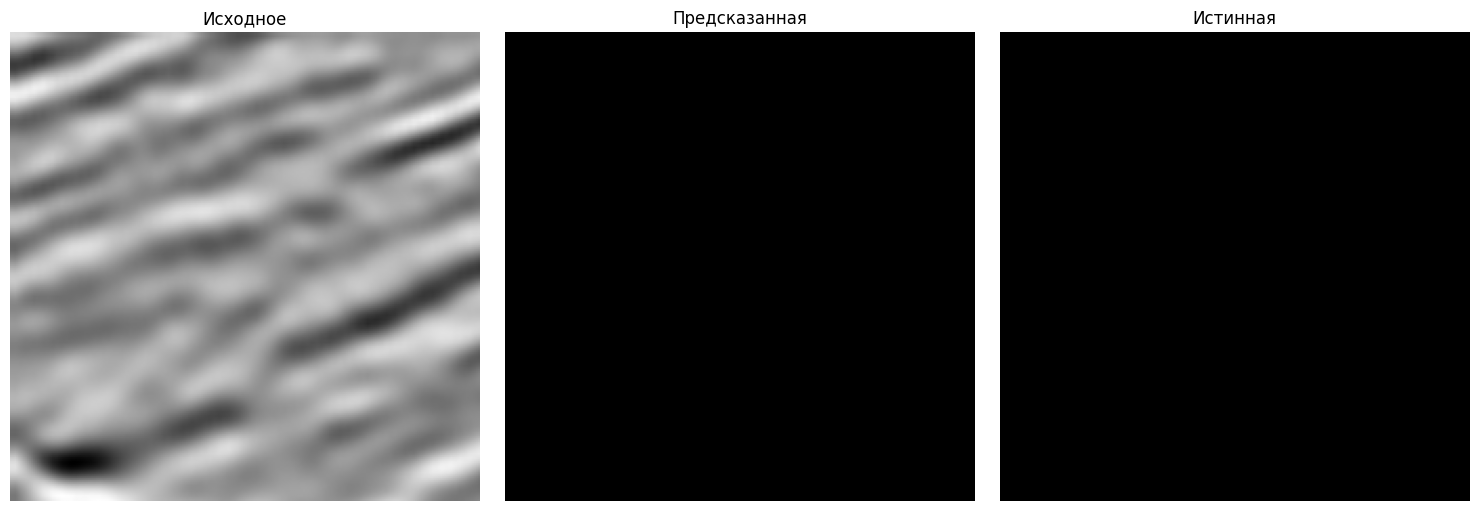

File: 994.dat, IoU: 0.0000, Dice: 0.0000


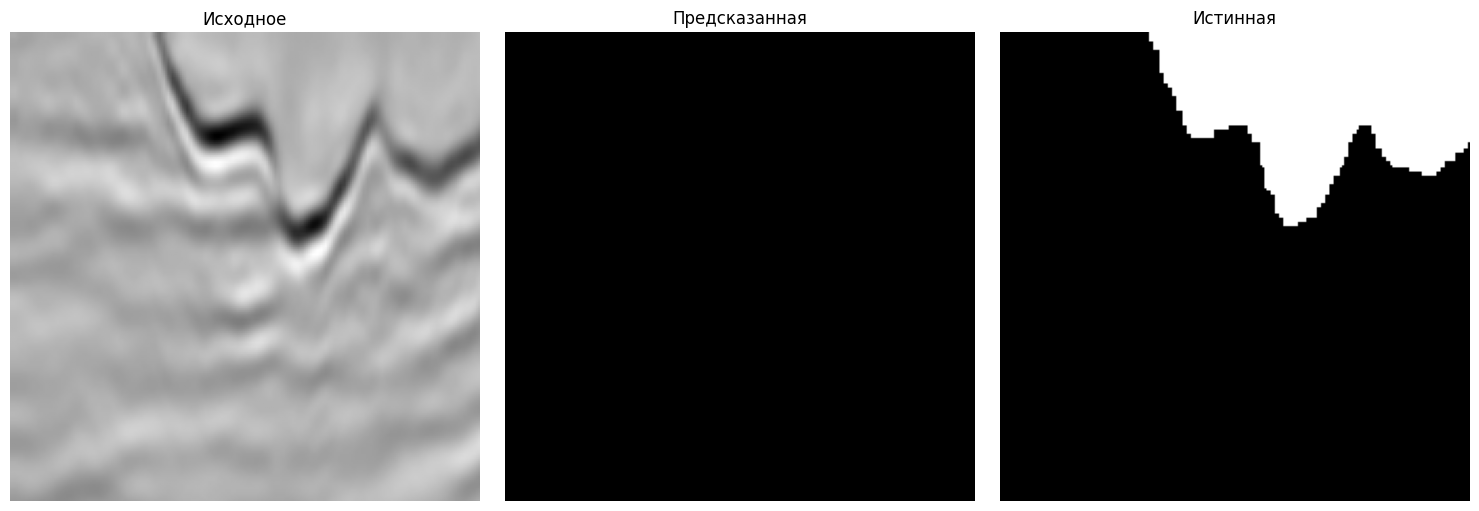

File: 995.dat, IoU: 0.0000, Dice: 0.0000


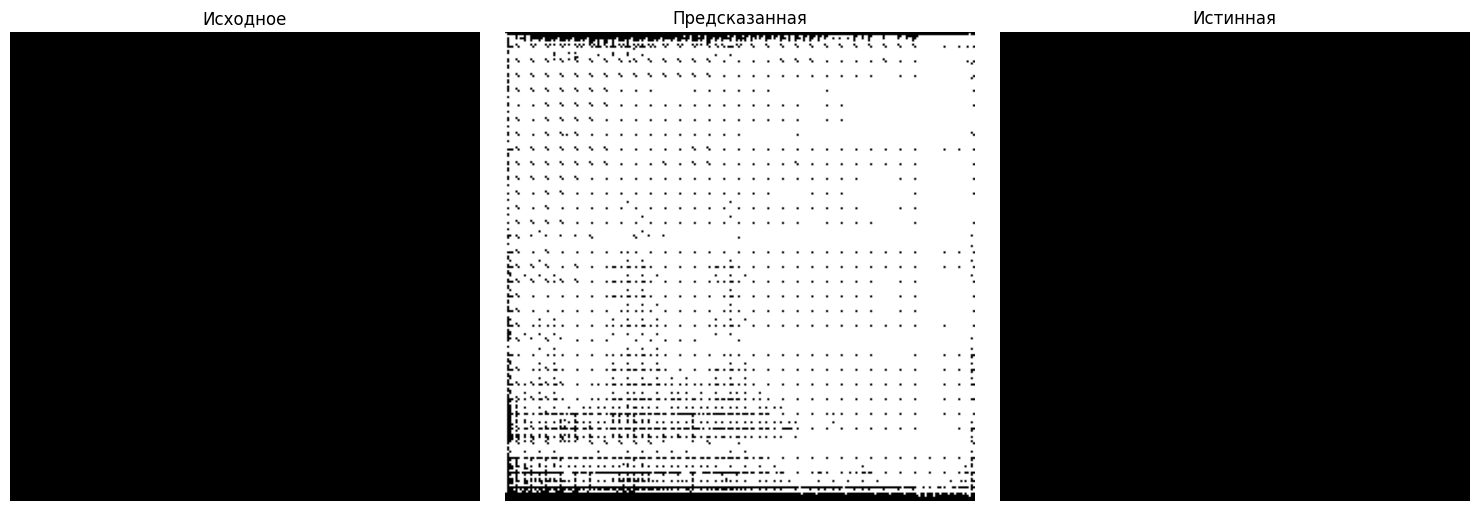

File: 996.dat, IoU: 0.0000, Dice: 0.0000


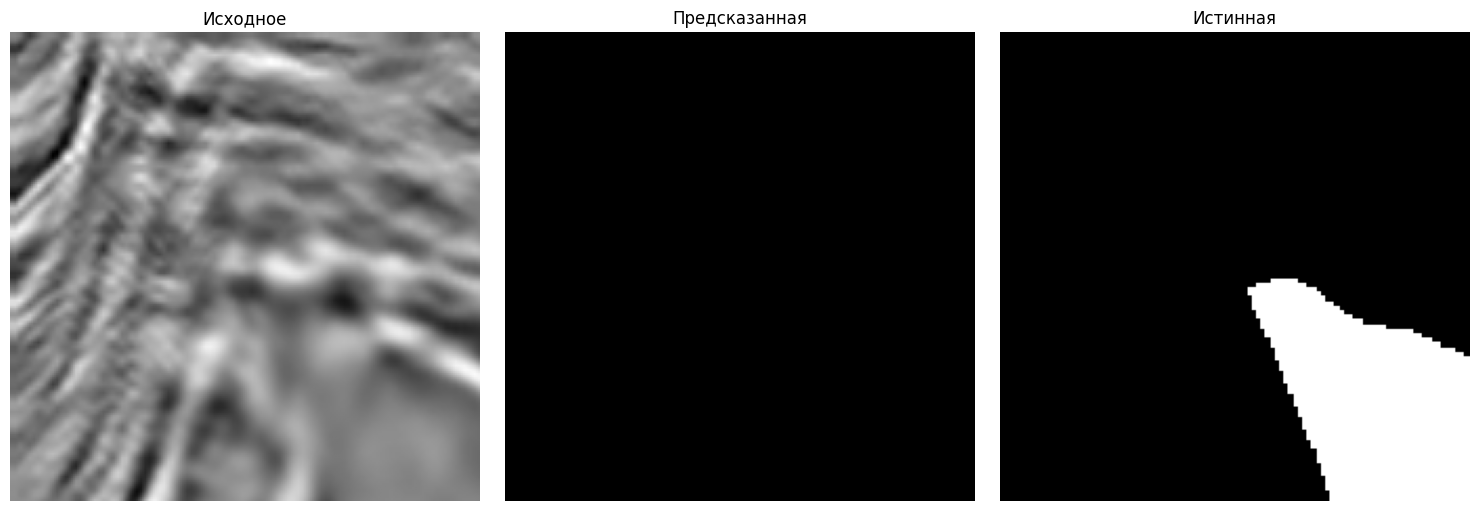

File: 997.dat, IoU: 0.0000, Dice: 0.0000


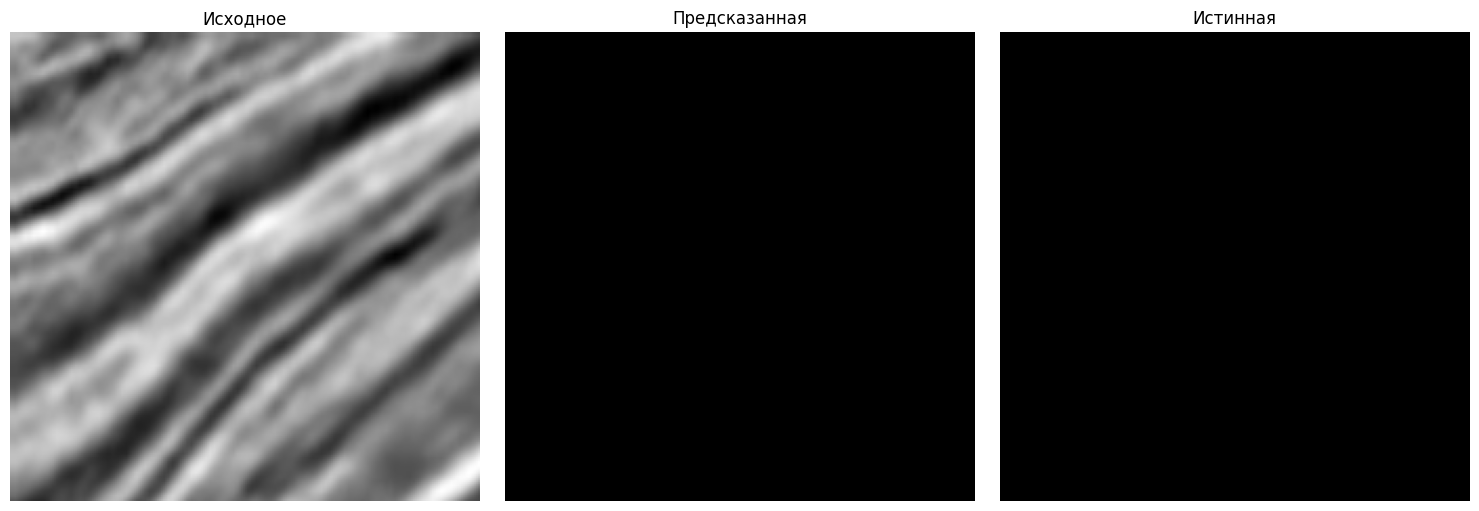

File: 998.dat, IoU: 0.0000, Dice: 0.0000


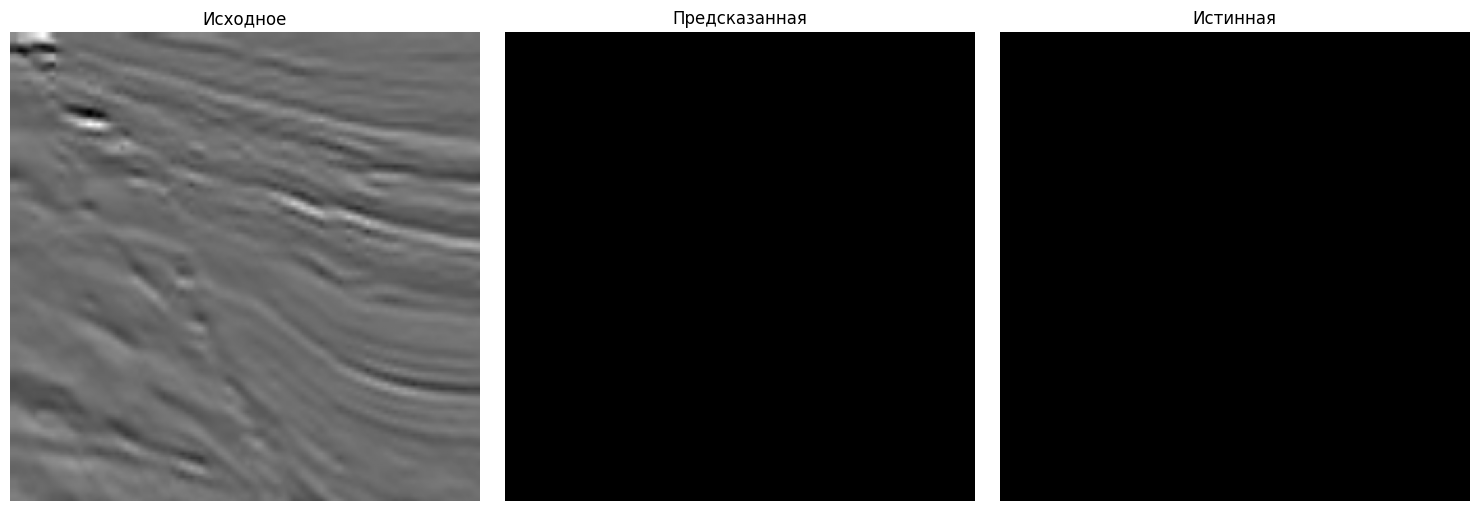

File: 999.dat, IoU: 0.0000, Dice: 0.0000


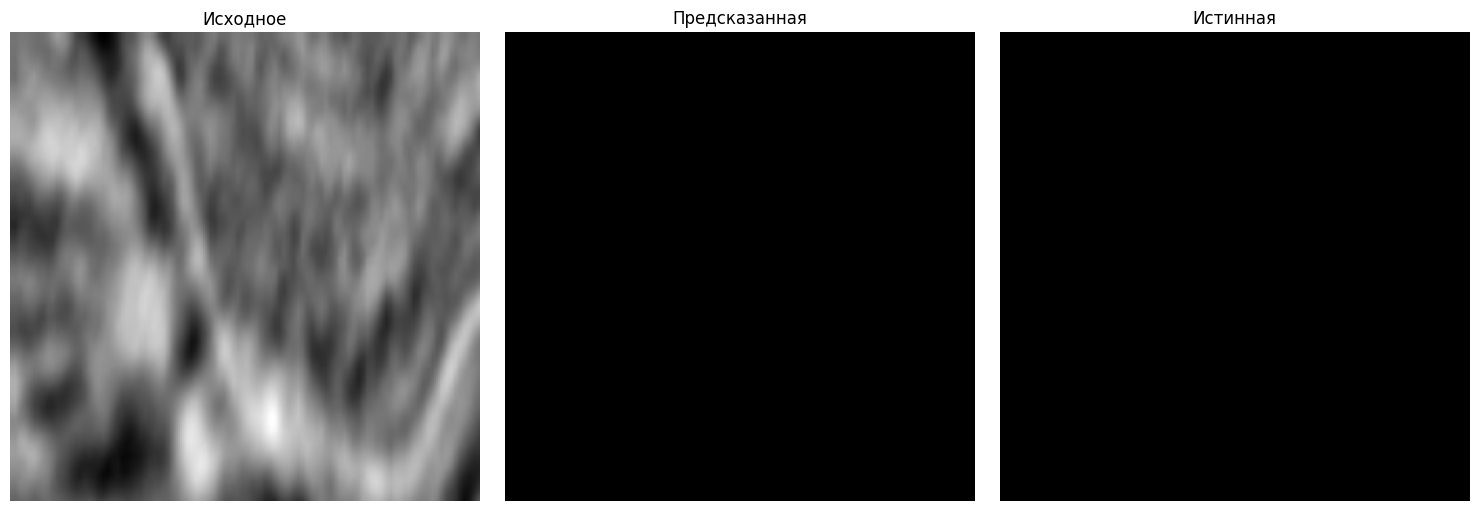

In [15]:
ious = []
dices = []

for filename in val_files:
    seismic_path = os.path.join(seismic_dir, filename)
    label_path   = os.path.join(label_dir, filename)  # Предполагаем, что имя файла такое же

    seismic = load_dat_file(seismic_path)
    label   = load_dat_file(label_path)

    # Если исходное изображение одноканальное, дублируем канал для создания 2-канального изображения
    if seismic.ndim == 2:
        seismic_img = np.stack([seismic, seismic, seismic], axis=-1)
    else:
        seismic_img = seismic

    predictor.set_image(seismic_img)

    # Выполняем предсказание (если масок несколько – берём первую)
    masks, scores, logits = predictor.predict()
    if len(masks) > 0:
        pred_mask = masks[0]
    else:
        pred_mask = np.zeros_like(label)

    # Изменяем размер предсказанной маски, чтобы она соответствовала размеру метки
    pred_mask = cv2.resize(pred_mask.astype(np.uint8), (label.shape[1], label.shape[0]))

    # Вычисляем метрики для данного файла
    iou, dice = compute_metrics(pred_mask, label)
    ious.append(iou)
    dices.append(dice)

    print(f"File: {filename}, IoU: {iou:.4f}, Dice: {dice:.4f}")

    # Визуализация: три изображения – исходное, предсказанная и истинная маска
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Исходное изображение (отображаем в градациях серого)
    axes[0].imshow(seismic, cmap='gray')
    axes[0].set_title("Исходное")
    axes[0].axis('off')
    
    # Предсказанная маска
    axes[1].imshow(pred_mask, cmap='gray')
    axes[1].set_title("Предсказанная")
    axes[1].axis('off')
    
    # Истинная маска
    axes[2].imshow(label, cmap='gray')
    axes[2].set_title("Истинная")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()



In [13]:
avg_iou = np.mean(ious)
avg_dice = np.mean(dices)

print(f"\nAverage IoU over validation set: {avg_iou:.4f}")
print(f"Average Dice coefficient over validation set: {avg_dice:.4f}")


Average IoU over validation set: 0.0000
Average Dice coefficient over validation set: 0.0000
